### SMS SPAM DETECTION USING RNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [2]:
# Downloading Dataset
dataset = pd.read_csv(r'SMSSpamCollection.txt', sep='\t', names=['label', 'message'])

In [3]:
print(dataset.head())
print("----------------------  -------------------------")
print(dataset.groupby('label').describe())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
----------------------  -------------------------
      message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4


In [4]:
# Preprocessing
dataset['label'] = dataset['label'].map({'spam': 1, 'ham': 0})
X = dataset['message'].values
y = dataset['label'].values

In [5]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tokeniser = tf.keras.preprocessing.text.Tokenizer()
tokeniser.fit_on_texts(X_train)

# Save the tokenizer using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokeniser, handle, protocol=pickle.HIGHEST_PROTOCOL)

encoded_train = tokeniser.texts_to_sequences(X_train)
encoded_test = tokeniser.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[387, 245, 325, 450, 917, 432, 1, 1323, 169, 2377], [19, 4, 1021, 112, 93, 6, 40, 358]]


In [6]:
# Padding
max_length = 20
padded_train = tf.keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = tf.keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train[30:34])

[[  14   61  388  540 3557   23 3558    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 474   59   35   10   61   22   63   75   76    0    0    0    0    0
     0    0    0    0    0    0]
 [  36  727  180   26 3559 2396  452   41    9 1850    0    0    0    0
     0    0    0    0    0    0]
 [ 518 2397  158   73  243   10   48   92    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [7]:
vocab_size = len(tokeniser.word_index) + 1

In [8]:
# Model definition
model=tf.keras.models.Sequential([
   tf.keras.layers.Embedding(input_dim=vocab_size,output_dim= 24, input_length=max_length),
   tf.keras.layers.SimpleRNN(24, return_sequences=False),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='min', patience=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 24)            180048    
                                                                 
 simple_rnn (SimpleRNN)      (None, 24)                1176      
                                                                 
 dense (Dense)               (None, 64)                1600      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 184937 (722.41 KB)
Trainable params: 184937 (722.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
# Model training
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test),
         callbacks=[early_stop]
         )

Epoch 1/50
122/122 [==============================] - 2s 7ms/step - loss: 0.2136 - accuracy: 0.9249 - val_loss: 0.0720 - val_accuracy: 0.9791
Epoch 2/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0435 - accuracy: 0.9879 - val_loss: 0.0476 - val_accuracy: 0.9868
Epoch 3/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.0479 - val_accuracy: 0.9868
Epoch 4/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0667 - val_accuracy: 0.9833
Epoch 5/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.0659 - val_accuracy: 0.9850
Epoch 6/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0501 - val_accuracy: 0.9839
Epoch 7/50
122/122 [==============================] - 1s 5ms/step - loss: 5.1659e-04 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9797
Ep

In [11]:
# Generate predictions after model training
preds = (model.predict(padded_test) > 0.5).astype("int32")

53/53 [==============================] - 0s 1ms/step


In [12]:
# Classification report
print("Classification Report")
print(classification_report(y_test, preds))

# Accuracy score
acc_sc = accuracy_score(y_test, preds)
print(f"Accuracy : {round(acc_sc * 100, 2)}")

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1448
           1       0.95      0.89      0.92       224

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672

Accuracy : 97.91


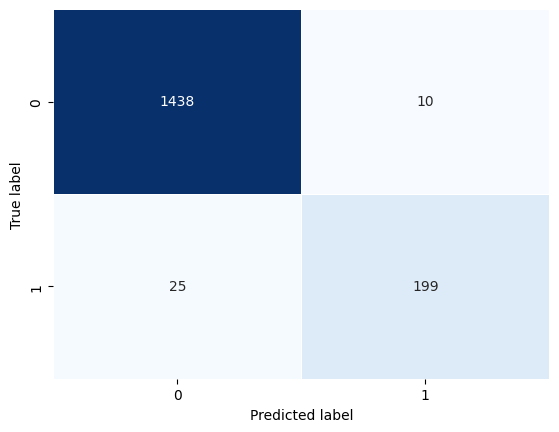

In [13]:
# Confusion matrix plotting
mtx = confusion_matrix(y_test, preds)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, cmap="Blues", cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()  # Display the plot

In [14]:
# Save the trained model
model.save("spammodel.h5")
spam_model = tf.keras.models.load_model('spammodel.h5')

d:\STUDY\Sem3\deeplearning\DLENV\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
def predict_message(input_text):
    # Process input text similarly to training data
    encoded_input = tokeniser.texts_to_sequences([input_text])
    padded_input = tf.keras.preprocessing.sequence.pad_sequences(encoded_input, maxlen=max_length, padding='post')
    
    # Get the probabilities of being classified as "Spam" for each input
    predictions = spam_model.predict(padded_input)
    
    # Define a threshold (e.g., 0.5) for classification
    threshold = 0.5

    # Make the predictions based on the threshold for each input
    results = []
    for prediction in predictions:
        if prediction > threshold:
            results.append("Spam")
        else:
            results.append("Not spam")
    
    return results


In [17]:
# Take user input for prediction
user_input =('Your free ringtone is waiting to be collected. Simply text the password "MIX" to 85069 to verify. Get Usher and Britney. FML, PO Box 5249, MK17 92H. 450Ppw 16 haWatching telugu movie..wat abt u?')
prediction_result = predict_message(user_input)
print(f"Message: {user_input} \nThe message is classified as: {prediction_result}")

1/1 [==============================] - 0s 139ms/step
Message: Your free ringtone is waiting to be collected. Simply text the password "MIX" to 85069 to verify. Get Usher and Britney. FML, PO Box 5249, MK17 92H. 450Ppw 16 haWatching telugu movie..wat abt u? 
The message is classified as: ['Spam']


In [18]:

user_input_1 = ('XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL')


prediction_result_1 = predict_message(user_input_1)
print(f"Message: {user_input_1} \nThe message is classified as: {prediction_result_1}")
    

1/1 [==============================] - 0s 20ms/step
Message: XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL 
The message is classified as: ['Spam']
